In [3]:
# !pip install lightgbm

In [4]:
import pandas as pd 
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
import os
import seaborn as sns
from wordcloud import WordCloud

In [5]:
# pip install wordcloud

In [6]:
data = pd.read_csv('./malicious_phish.csv')

In [7]:
# data.head()

In [8]:
# print(data.shape)

In [9]:
# data.type.value_counts()

In [10]:
# We will populate a wordcloud to represent text data, where the size of each word indicates its frequency or importance within the text. 

phishing_data = data[data.type == 'phishing']
malware_data = data[data.type == 'malware']
defacement_data = data[data.type == 'defacement']
benign_data = data[data.type == 'benign']

In [11]:
# # For wordcloud of phishing URL data

# phishing_wordcloud = " ".join(i for i in phishing_data.url)
# wordcloud = WordCloud(width=1600, height=800, colormap='Paired').generate(phishing_wordcloud)
# plt.figure(figsize=(12, 14), facecolor='k')
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.tight_layout (pad=0)
# plt.show()

In [12]:
# # For wordcloud of malware URL data

# malware_wordcloud = " ".join(i for i in malware_data.url)
# wordcloud = WordCloud(width=1600, height=800, colormap='Paired').generate(malware_wordcloud)
# plt.figure(figsize=(12, 14), facecolor='k')
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.tight_layout (pad=0)
# plt.show()

In [13]:
# # For wordcloud of defacement URL data

# defacement_wordcloud = " ".join(i for i in defacement_data.url)
# wordcloud = WordCloud(width=1600, height=800, colormap='Paired').generate(defacement_wordcloud)
# plt.figure(figsize=(12, 14), facecolor='k')
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.tight_layout (pad=0)
# plt.show()

In [14]:
# # For wordcloud of benign URL data

# benign_wordcloud = " ".join(i for i in benign_data.url)
# wordcloud = WordCloud(width=1600, height=800, colormap='Paired').generate(benign_wordcloud)
# plt.figure(figsize=(12, 14), facecolor='k')
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.tight_layout (pad=0)
# plt.show()

# 

# Data Pre Processing

# 

In [15]:
# We want to detect if there was use of IP Address in the domain and we'll create a column called ['use_of_ip'] with numeric values for that.

import re

def use_of_ip_address(url):
    match = re.search('(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match: 
        return 1
    else:
        return 0

data['use_of_ip'] = data['url'].apply(lambda i: use_of_ip_address(i))

In [16]:
# We want to find abnormal urls, we define abnormal urls as those urls whose domain names are not present in the urls

from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        return 1
    else:
        return 0

data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

In [17]:
# We want to check if a given URL is indexed by Google.

!pip install googlesearch-python

from googlesearch import search

def google_index(url):
    site = search(url, 5)
    return 1 if site else 0

data['google_index'] = data['url'].apply(lambda i: google_index(i))

In [18]:
# We want to count the nuumber of dots (.) in a url

def count_url(url):
    count_of_dots = url.count('.')
    return count_of_dots 

data['count_of_dots'] = data['url'].apply(lambda i: count_url(i))

In [19]:
# We want to count the number of 'www' in each URL

def count_www(url):
    url.count('www')
    return url.count('www')

data['count_www'] = data['url'].apply(lambda i: count_www(i))

In [20]:
# We want to count the check and count the occurence of '@' in each URL

def count_at(url):
    return url.count('@')

data['count_of_@'] = data['url'].apply(lambda i: count_at(i))

In [21]:
# We wwant to check the number of directories '/' present in each URL 

def count_of_dir(url):
    count_of_dir = urlparse(url).path
    return count_of_dir.count('/')

data['count_of_/'] = data['url'].apply(lambda i: count_of_dir(i))

In [22]:
# We want to count the numeber of embeded domains. Represented by '//'

def count_of_domains(url):
    count_of_domains = urlparse(url).path
    return count_of_domains.count('//')

data['count_of_//'] = data['url'].apply(lambda i: count_of_domains(i))

In [23]:
# We want to check for urls that have been shortened with url shortners 

def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

data['short_url'] = data['url'].apply(lambda i: shortening_service(i))

In [24]:
# We want to count the number of 'https' present in each url

def count_https(url):
    return url.count('https')

data['count_https'] = data['url'].apply(lambda i: count_https(i))

In [25]:
# We want to count the number of 'http' oresent in each url

def count_http(url):
    return url.count('http')

data['count_http'] = data['url'].apply(lambda i: count_http(i))

In [26]:
# We want to count the number of percentage signs '%' in each url

def count_per(url):
    return url.count('%')

data['count_of_%'] = data['url'].apply(lambda i: count_per(i))

In [27]:
# We want to count the number of question marks '?' in each url 

def count_ques(url):
    return url.count('?')

data['count_of_?'] = data['url'].apply(lambda i: count_ques(i))

In [28]:
# We want to count the number of hyphens in each url

def count_hyphen(url):
    return url.count('-')

data['count-'] = data['url'].apply(lambda i: count_hyphen(i))

In [29]:
# We want to count the number of equals '=" in each url 

def count_equal(url):
    return url.count('=')

data['count='] = data['url'].apply(lambda i: count_equal(i))

In [30]:
# We want to count the length of each url

def count_length(url):
    return len(str(url))

data['count_of_length'] = data['url'].apply(lambda i: count_length(i))

In [31]:
# We want to check the length of the hostname/network location in each url

def hostname_length(url):
    return len(urlparse(url).netloc)

data['hostname_length'] = data['url'].apply(lambda i: hostname_length(i))

In [32]:
# We want to check for suspicious words in each url

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match: 
        return 1
    else:
        return 0

data['susp_words'] = data['url'].apply(lambda i: suspicious_words(i))

In [33]:
# We want to count the number of digits in each url

def count_digits(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
        return digits

data['count_of_digits'] = data['url'].apply(lambda i: count_digits(i))

In [34]:
# We want to count the number of alphabets/letters in each url

def count_alphabets(url):
    alphabets = 0
    for i in url:
        if i.isalpha():
            alphabets = alphabets + 1
        return alphabets

data['count_of_alphabets'] = data['url'].apply(lambda i: count_alphabets(i))

In [35]:
# We want to get the length of the first directory

!pip install tld 

from urllib.parse import urlparse
from tld import get_tld
import os.path 

def length_fd(url):
    url_directory = urlparse(url).path
    try:
        return len(url_directory.split('/')[1])
    except:
        return 0

data['length_of_fd'] = data['url'].apply(lambda i: length_fd(i))

In [36]:
# We want to find the length of the top level domain

data['tld'] = data['url'].apply(lambda i: get_tld(i, fail_silently=True))

def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

data['tld_length'] = data['tld'].apply(lambda i: tld_length(i))

In [37]:
data = data.drop('tld', axis=1)

In [38]:
# data.head()

#

# Exploratory Data Analysis

# 

In [39]:
# In this section we will explore visual representations of some data points so as to have a high level idea of what is going on in our data

In [40]:
data.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index',
       'count_of_dots', 'count_www', 'count_of_@', 'count_of_/', 'count_of_//',
       'short_url', 'count_https', 'count_http', 'count_of_%', 'count_of_?',
       'count-', 'count=', 'count_of_length', 'hostname_length', 'susp_words',
       'count_of_digits', 'count_of_alphabets', 'length_of_fd', 'tld_length'],
      dtype='object')

# 1. Distribution of 'use_of_ip'

In [41]:
# import seaborn as sns
# sns.set(style="darkgrid")
# ax = sns.countplot(y='type', data=data, hue='use_of_ip')

# 2. Distribution of 'abnormal_url'

In [42]:
# sns.set(style="darkgrid")
# ax = sns.countplot(y='type', data=data, hue='abnormal_url')

# 3. Distribution of Google Index

In [43]:
# sns.set(style="darkgrid")
# ax = sns.countplot(y="type", data=data,hue="google_index")

# 4. Distribution of 'short_url'

In [44]:
# sns.set(style="darkgrid")
# ax = sns.countplot(y="type", data=data,hue="short_url")

# 5. Distribution of 'susp_words'

In [45]:
# sns.set(style="darkgrid")
# ax = sns.countplot(y="type", data=data,hue="susp_words")

# 6. Distribution of 'count_of_dots'

In [46]:
# sns.set(style="darkgrid")
# sns.catplot(x="type", y="count_of_dots", kind="box", data=data)

# 7. Distribution of 'count_www'

In [47]:
# sns.set(style="darkgrid")
# sns.catplot(x="type", y="count_www", kind="box", data=data)

# 8. Distribution of 'count_of_@'

In [48]:
# sns.set(style="darkgrid")
# sns.catplot(x="type", y="count_of_@", kind="box", data=data)

# 9. Distribution of 'count_of_/'

In [49]:
# sns.set(style="darkgrid")
# sns.catplot(x="type", y="count_of_/", kind="box", data=data)

# Distribution of 'tld_length'

In [50]:
# sns.set(style="darkgrid")
# sns.catplot(x="type", y="tld_length", kind="box", data=data)

#

# Feature engineering

#

In [51]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['type_code'] = le.fit_transform(data['type'])
data['type_code'].value_counts()

type_code
0    428103
1     96457
3     94111
2     32520
Name: count, dtype: int64

In [52]:
# Creation of Feature & Target
#Predictor Variables
# filtering out google_index as it has only 1 value

X = data[['use_of_ip', 'abnormal_url', 'count_of_dots', 'count_www', 'count_of_@', 'count_of_/', 'count_of_//',
       'short_url', 'count_https', 'count_http', 'count_of_%', 'count_of_?',
       'count-', 'count=', 'count_of_length', 'hostname_length', 'susp_words',
       'count_of_digits', 'count_of_alphabets', 'length_of_fd', 'tld_length']]

# Target Variable
y = data["type_code"]

In [53]:
X.head()

,use_of_ip,abnormal_url,count_of_dots,count_www,count_of_@,count_of_/,count_of_//,short_url,count_https,count_http,...,count_of_?,count-,count=,count_of_length,hostname_length,susp_words,count_of_digits,count_of_alphabets,length_of_fd,tld_length
0,0,0,2,0,0,0,0,0,0,0,...,0,1,0,16,0,0,0,1,0,-1
1,0,0,2,0,0,2,0,0,0,0,...,0,0,0,35,0,0,0,1,5,-1
2,0,0,2,0,0,3,0,0,0,0,...,0,0,0,31,0,0,0,1,7,-1
3,0,1,3,1,0,1,0,0,0,1,...,1,1,4,88,21,0,0,1,9,2
4,0,1,2,0,0,1,0,0,0,1,...,1,1,3,235,23,0,0,1,9,3


In [54]:
X.columns

Index(['use_of_ip', 'abnormal_url', 'count_of_dots', 'count_www', 'count_of_@',
       'count_of_/', 'count_of_//', 'short_url', 'count_https', 'count_http',
       'count_of_%', 'count_of_?', 'count-', 'count=', 'count_of_length',
       'hostname_length', 'susp_words', 'count_of_digits',
       'count_of_alphabets', 'length_of_fd', 'tld_length'],
      dtype='object')

# 

# Train Test Split

#

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, shuffle=True, random_state=5)

#

# Model Building 

#

### 1. Random Forest Classifier

In [106]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_features='sqrt')
rf.fit(X_train, y_train)

import pickle
pickle.dump(rf, open('model.pkl','wb'))

y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names=['benign', 'defacement', 'phishing', 'malware']))

score = metrics.accuracy_score(y_test, y_pred_rf)
precision = metrics.precision_score(y_test, y_pred_rf, average='weighted')
f1 = metrics.f1_score(y_test, y_pred_rf, average='weighted')
print("accuracy:   %0.3f" % score)
print("Precision:   %0.3f" % precision)
print("F1 Score:    %0.3f" % f1)

              precision    recall  f1-score   support

      benign       0.97      0.98      0.98     85621
  defacement       0.98      0.99      0.98     19292
    phishing       0.98      0.94      0.96      6504
     malware       0.90      0.85      0.87     18822

    accuracy                           0.96    130239
   macro avg       0.96      0.94      0.95    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.963
Precision:   0.963
F1 Score:    0.963


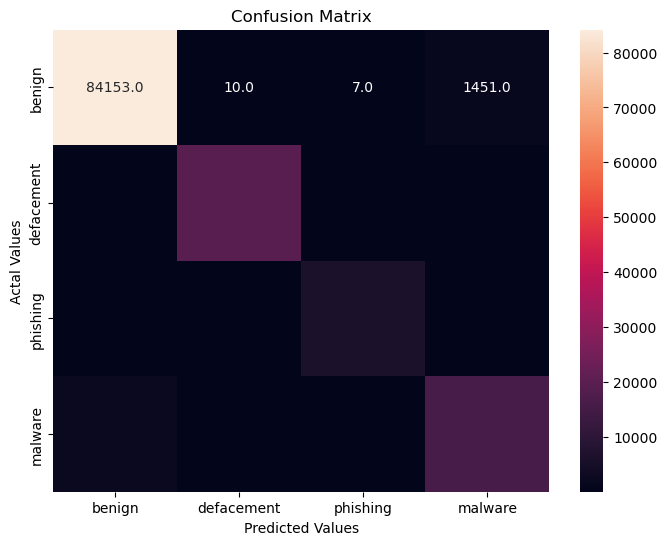

In [57]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

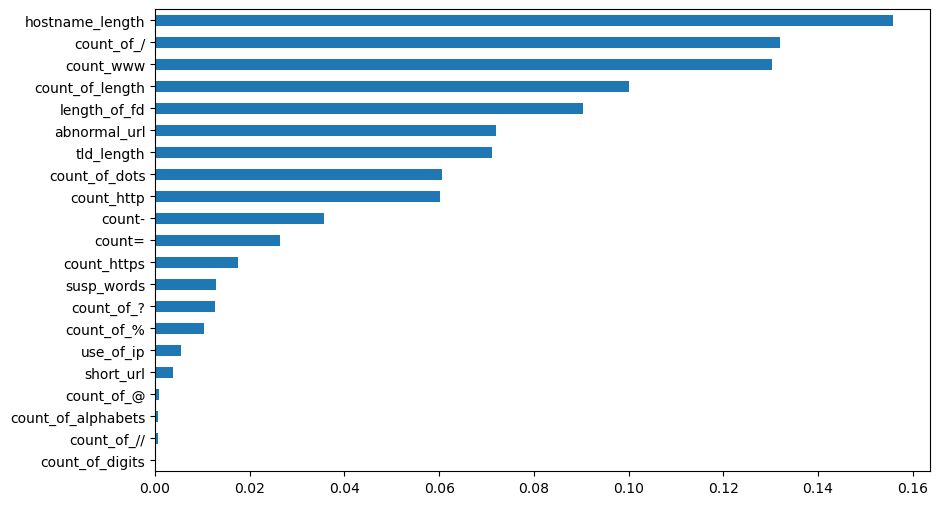

In [58]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

### 2. Light GBM Classifier 

In [59]:
# from lightgbm import LGBMClassifier
# lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',n_jobs = 5, 
#           silent = True, random_state=5)
# LGB_C = lgb.fit(X_train, y_train)
# y_pred_lgb = LGB_C.predict(X_test)
# print(classification_report(y_test,y_pred_lgb,target_names=['benign', 'defacement','phishing','malware']))

# score = metrics.accuracy_score(y_test, y_pred_lgb)
# precision = precision_score(y_test, y_pred_rf, average='weighted')
# f1 = f1_score(y_test, y_pred_rf, average='weighted')
# print("accuracy:   %0.3f" % score)
# print("Precision:   %0.3f" % precision)
# print("F1 Score:    %0.3f" % f1)



In [60]:
# cm = confusion_matrix(y_test, y_pred_lgb)
# cm_df = pd.DataFrame(cm,
#                      index = ['benign', 'defacement','phishing','malware'], 
#                      columns = ['benign', 'defacement','phishing','malware'])
# plt.figure(figsize=(8,6))
# sns.heatmap(cm_df, annot=True,fmt=".1f")
# plt.title('Confusion Matrix')
# plt.ylabel('Actal Values')
# plt.xlabel('Predicted Values')
# plt.show()

In [61]:
# feat_importances = pd.Series(lgb.feature_importances_, index=X_train.columns)
# feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

# 3. XGboost Classifier

In [62]:
# xgb_c = xgb.XGBClassifier(n_estimators= 100)
# xgb_c.fit(X_train,y_train)
# y_pred_x = xgb_c.predict(X_test)
# print(classification_report(y_test,y_pred_x,target_names=['benign', 'defacement','phishing','malware']))


# score = metrics.accuracy_score(y_test, y_pred_x)
# precision = metrics.precision_score(y_test, y_pred_rf, average='weighted')
# f1 = metrics.f1_score(y_test, y_pred_rf, average='weighted')
# print("accuracy:   %0.3f" % score)
# print("Precision:   %0.3f" % precision)
# print("F1 Score:    %0.3f" % f1)

In [63]:
# feat_importances = pd.Series(xgb_c.feature_importances_, index=X_train.columns)
# feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

# Prediction

In [64]:
def main(url):
    
    status = []
    
    status.append(use_of_ip_address(url))
    status.append(abnormal_url(url))
    status.append(count_url(url))
    status.append(count_www(url))
    status.append(count_at(url))
    status.append(count_of_dir(url))
    status.append(count_of_domains(url))
    
    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))
    
    status.append(count_per(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))
    
    status.append(count_length(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(count_digits(url))
    status.append(count_alphabets(url))
    status.append(length_fd(url))
    tld = get_tld(url,fail_silently=True)
      
    status.append(tld_length(tld))
    
    
    

    return status

In [65]:
def get_prediction_from_url(test_url):
    features_test = main(test_url)
    # Due to updates to scikit-learn, we now need a 2D array as a parameter to the predict function.
    features_test = np.array(features_test).reshape((1, -1))

    

    pred = rf.predict(features_test)
    if int(pred[0]) == 0:
        
        res="SAFE"
        return res
    elif int(pred[0]) == 1.0:
        
        res="DEFACEMENT"
        return res
    elif int(pred[0]) == 2.0:
        res="PHISHING"
        return res
        
    elif int(pred[0]) == 3.0:
        
        res="MALWARE"
        return res

In [100]:
# urls = ['titaniumcorporate.co.za','en.wikipedia.org/wiki/North_Dakota']
# for url in urls:
#      print(get_prediction_from_url(url))

In [103]:
# import pickle
# pickle.dump(rf, open('model.pkl','wb'))

In [72]:
# mod = pickle.load(open('model.pkl', 'rb'))

In [69]:
# mod('en.wikipedia.org/wiki/North_Dakota')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


'SAFE'

In [83]:
# m = 'titaniumcorporate.co.za'
# print(model(m))

In [88]:
# get_prediction_from_url

<function __main__.get_prediction_from_url(test_url)>